In this analysis I want to evaluate the feature that best describes SalePrice feature of my dataset.
I've decided to use two approaches and compare them: to calculate the correlation between the features and to use Feature Importance.

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#I want to also evaluate the categorical features
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#To deal with NaN values of categorical features
from sklearn.impute import SimpleImputer

#Later I want to compare this analysis with Feature Importance analysis
from sklearn.ensemble import ExtraTreesClassifier

#Loading the data
data = pd.read_csv('dataset.csv')
prices = data['SalePrice']
features = data.drop('SalePrice', axis=1)


In [2]:
#Statistics
minimum_price = np.amin(prices)
maximum_price = np.amax(prices)
mean_price = np.mean(prices)
median_price = np.median(prices)
std_price = np.std(prices)

print("Minimum price: ${}".format(minimum_price))
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price: ${}".format(median_price))
print("Standard deviation of prices price: ${}".format(std_price))

Minimum price: $34900
Maximum price: $755000
Mean price: $180921.19589041095
Median price: $163000.0
Standard deviation of prices price: $79415.29188606751


The sale prices range from 34.9k to 755k.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

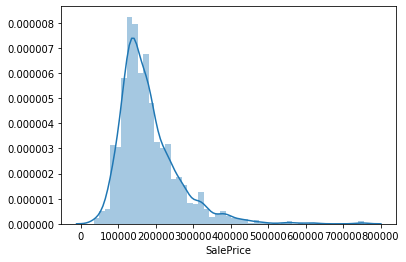

In [3]:
#Analysing the features
data.info()

#Sale price distribution
sns.distplot(prices)

It seems that we have 38 continuous and 43 categorical features.
Based on the SalePrice distribution, there are more samples with a sale price between 100k and 200k.


To beggin the analysis, I want to separate the categorical from the continuous features.

In [4]:
continuous = data.select_dtypes(include=['float64','int64']).copy()
categorical = data.select_dtypes(include=['object']).copy()

While analysing data_description, we can see that there are three discrete features that are not objects: MSSubClass, OverallQual and OverallCond.
Lets extract them from continuous and add them to categorical.

In [5]:
continuous = continuous.drop(["MSSubClass","OverallQual","OverallCond"], axis = 1)
categorical["MSSubClass"] = data["MSSubClass"]
categorical["OverallQual"] = data["OverallQual"]
categorical["OverallCond"] = data["OverallCond"]


Now we have all categorical features in categorical dataset. Since some of them have hierarchy and some have not, the next step is to divide them with respect to this. The ones with hierarchy can have LabelEncoder applied to, the others should have OneHotEncoder, since LabelEncoder shouldn't be applied to non-hierarchical features.

The ones with hierarchy are: ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond, PoolQC.

In [6]:
#Categorical featurel without hierarchy (categ)
categ = categorical.copy()
#Categorical features with hierarchy (categ_hier)
categ_hier = pd.DataFrame()

hierarchy_names = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PoolQC']
for name in hierarchy_names:
    categ_hier[name] = data[name]
    categ = categ.drop(name, axis=1) 


Now we organized our data: continuous features, categorical non-hierarchical features and categorical hierarchical features.

Let's start analysing the continuous features.
To do so, we are going to check the ones with null values and see the porcentage of it, so we can deal it them.

Initially, ID won't be important to our analysis, since it does not influence the SalesPrice

In [7]:
continuous = continuous.drop(['Id'], axis=1)

In [8]:
print('% of null values:')
for feature in continuous:
    porcentage_of_zeros = continuous[feature].isnull().sum()/1460
    if porcentage_of_zeros != 0:
        print(feature + " " + str(porcentage_of_zeros))

% of null values:
LotFrontage 0.1773972602739726
MasVnrArea 0.005479452054794521
GarageYrBlt 0.05547945205479452


I see that in continuous dataset the LotFrontage feature has the higher porcentage of null values: 17.7%. As this number is not very high, I'm going to  decided to deal with the null values using MostFrequent strategy in SimpleImputer.

In [9]:
for feature in continuous:
    porcentage_of_zeros = continuous[feature].isnull().sum()/1460
    if porcentage_of_zeros != 0:
        imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
        continuous[feature] = imp.fit_transform(continuous)

I'm going to check the correlation between the features and SalePrice, by using .corr(). I decided to use Pearson method and visualize it in a heatmap.

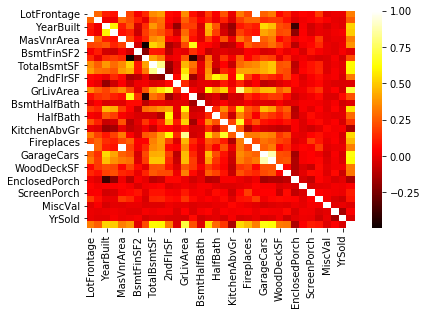

In [10]:
continuous_corr = continuous.corr(method="pearson")
sns.heatmap(continuous_corr, cmap=plt.cm.hot, mask = continuous_corr.isnull())

In [11]:
# Listing the correlation between each feature and SalePrice
coef = abs(continuous_corr["SalePrice"])

#The most relevant features will be the ones with a higher absolute value for the coefficient.
selected_features = coef[coef>0.5]
print(selected_features)

YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64


Given the coefficients, we know that the higher the value, the better its feature describes SalePrice.
Based on the analysis for the continuous features, GrLivArea best describes SalePrice feature (coefficient of 0.708624).

Now I am going to analyse the categorical features.
Starting with non-hierarchical dataset, categ, we will find the features with null values, deal with them, apply OneHotEncoder and calculate the correlation using .corr().
I need to add SalePrice to it in the end, before calculating the correlation.

In [12]:
for feature in categ:
    porcentage_of_zeros = categ[feature].isnull().sum()/1460
    if porcentage_of_zeros != 0:
        print(feature + " " + str(porcentage_of_zeros))

Alley 0.9376712328767123
MasVnrType 0.005479452054794521
Electrical 0.0006849315068493151
GarageType 0.05547945205479452
Fence 0.8075342465753425
MiscFeature 0.963013698630137


We see the ones with high porcentage of null values: Alley (93.7%), Fence (80.75%) and MiscFeature (96.3%).
I won't calculate their correlation, since I believe that dealing with so many null values by applying SimpleImputer with MostFrequent strategy could affect the quality of my analysis.
Let's visualize them in a boxplot.

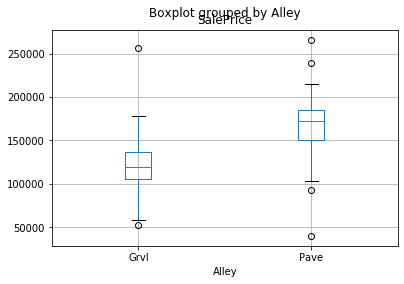

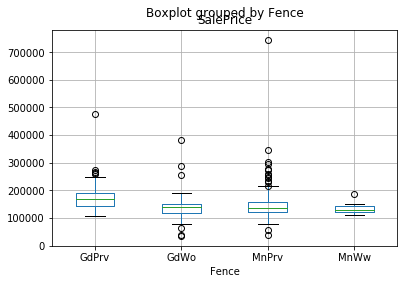

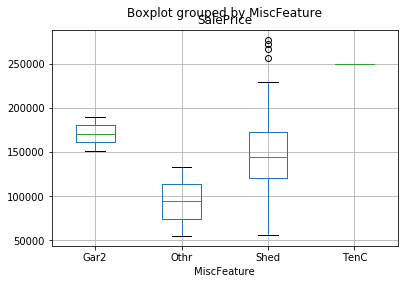

In [13]:
data.boxplot("SalePrice","Alley")
data.boxplot("SalePrice","Fence")
data.boxplot("SalePrice","MiscFeature")

In Alley boxplot we notice that a paved alley could be related to a higher price of the house, when compared to gravel alleys.
In Fence boxplot we can't see a good relation between the types of fences and the SalePrice. It happened also for MiscFeatue. However it is interesting to notice the houses with a second garage (Gar2) have most of its prices between 150k and approx. 180k. Even thought I believe that an expensive house would have a second garage, we have to remember that 96.3% of the values of MiscFeature are null. This indicates the importance of having more data.

Now we will delete them from categ dataset and analyse the rest.

In [14]:
categ = categ.drop(["Alley","Fence","MiscFeature"], axis=1)

Now we will deal with NaN values and apply OneHotEncoder (OHE).
It's important to notice that we don't have SalePrice feature in categorical_to_numeric data set, as we don't want to change its values with OHE. We will add it in the end, calculate the correlation using Pearson method and select the ones with a higher coefficient.


In [15]:
for feature in categ:
    porcentage_of_zeros = categ[feature].isnull().sum()/1460
    if porcentage_of_zeros != 0:
        imp = SimpleImputer(missing_values=np.nan,strategy="most_frequent")
        categ[feature] = imp.fit_transform(categ)

In [16]:
#OneHotEncoder
OHE = OneHotEncoder(categories='auto')

for feature in categ:
    feature_OHE_arr = OHE.fit_transform(categ[[feature]]).toarray()
    categ[feature] = feature_OHE_arr
categ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 28 columns):
MSZoning         1460 non-null float64
Street           1460 non-null float64
LotShape         1460 non-null float64
LandContour      1460 non-null float64
Utilities        1460 non-null float64
LotConfig        1460 non-null float64
LandSlope        1460 non-null float64
Neighborhood     1460 non-null float64
Condition1       1460 non-null float64
Condition2       1460 non-null float64
BldgType         1460 non-null float64
HouseStyle       1460 non-null float64
RoofStyle        1460 non-null float64
RoofMatl         1460 non-null float64
Exterior1st      1460 non-null float64
Exterior2nd      1460 non-null float64
MasVnrType       1460 non-null float64
Foundation       1460 non-null float64
Heating          1460 non-null float64
CentralAir       1460 non-null float64
Electrical       1460 non-null float64
GarageType       1460 non-null float64
PavedDrive       1460 non-null floa

In [17]:
categ["SalePrice"] = data["SalePrice"]

In [18]:
#Pearson method
categ_corr = categ.corr(method="pearson")

coef_categ = abs(categ_corr["SalePrice"])

#Higher absolute values of the coefficient.
selected_features = coef_categ[coef_categ>0.2]
print(selected_features)

LotShape      0.223284
Foundation    0.204117
CentralAir    0.251328
PavedDrive    0.212630
SalePrice     1.000000
Name: SalePrice, dtype: float64


Higgest coefficient for the categ dataset: 0.251328 for CentralAir.

Now with hierarchical dataset, categ_hier, we will find the features with null values, deal with them, apply LabelEncoder and calculate the correlation using .corr().
I need to add SalePrice to it in the end, before calculating the correlation.

In [19]:
for feature in categ_hier:
    porcentage_of_zeros = categ_hier[feature].isnull().sum()/1460
    if porcentage_of_zeros != 0:
        print(feature + " " + str(porcentage_of_zeros))

BsmtQual 0.025342465753424658
BsmtCond 0.025342465753424658
BsmtExposure 0.026027397260273973
BsmtFinType1 0.025342465753424658
BsmtFinType2 0.026027397260273973
FireplaceQu 0.4726027397260274
GarageFinish 0.05547945205479452
GarageQual 0.05547945205479452
GarageCond 0.05547945205479452
PoolQC 0.9952054794520548


We see the ones with high porcentage of null values: PoolQC (99.5%) and FireplaceQu (47.3%).
Let's visualize them in a boxplot.

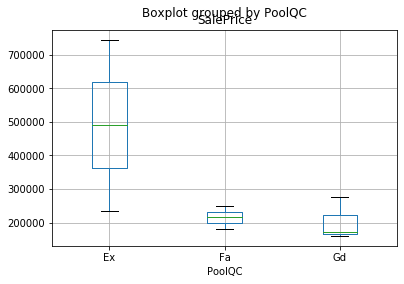

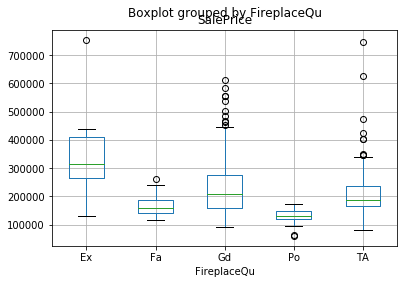

In [20]:
data.boxplot("SalePrice","PoolQC")
data.boxplot("SalePrice","FireplaceQu")

Even though the graphic of PoolQC shows a very symetrical boxplot for excellent pool quality, its range is very wide (approx. 240k to 740k. This makes sense, since pool quality couldn't describe so well SalePrice: ex.: a pool with excellent quality could be placed in areas where the prices are lower (location also interferes).

The graphic for FireplaceQu doesn't show a good relation between the feature and SalePrice. However it is interesting to see that most of the excellent Fireplaces tracked are related to a SalePrice between approx. 260k and 410k, which is above the high frequency prices tracked on sns.distplot(prices) (they range between 100k and 200k).   

Now we will delete them from categ_hier dataset and analyse the rest.

In [21]:
categ_hier = categ_hier.drop(["PoolQC","FireplaceQu"], axis=1)

Now we will deal with NaN values and apply LabelEncoder (LE).

We will add SalePrice in the end, calculate the correlation using Pearson method and select the ones with a higher coefficient.

BsmtQual and BsmtCond have 1423 out of 1460 non-null values. 
BsmtExposure and BsmtFinType2 have 1422 out of 1460. 
GarageQual, GarageCond and GarageFinish have 1379 out of 1460
Since it is not a big amount of NaN values, we will consider as they are NA values (no basement, no garage)

In [22]:
categ_hier["BsmtQual"].fillna("NA", inplace = True)
categ_hier["BsmtCond"].fillna("NA", inplace = True)
categ_hier["BsmtExposure"].fillna("NA", inplace = True)
categ_hier["BsmtFinType1"].fillna("NA", inplace = True)
categ_hier["BsmtFinType2"].fillna("NA", inplace = True)
categ_hier["GarageQual"].fillna("NA", inplace = True)
categ_hier["GarageCond"].fillna("NA", inplace = True)
categ_hier["GarageFinish"].fillna("NA", inplace = True)

In [23]:
#LabelEncoder
LE = LabelEncoder()

for feature in categ_hier:
    feature_LE = LE.fit_transform(categ_hier[feature])
    categ_hier[feature] = feature_LE

categ_hier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
ExterQual       1460 non-null int32
ExterCond       1460 non-null int32
BsmtQual        1460 non-null int32
BsmtCond        1460 non-null int32
BsmtExposure    1460 non-null int32
BsmtFinType1    1460 non-null int32
BsmtFinType2    1460 non-null int32
HeatingQC       1460 non-null int32
KitchenQual     1460 non-null int32
Functional      1460 non-null int32
GarageFinish    1460 non-null int32
GarageQual      1460 non-null int32
GarageCond      1460 non-null int32
dtypes: int32(13)
memory usage: 74.2 KB


In [24]:
categ_hier["SalePrice"] = data["SalePrice"]

In [25]:
#Pearson method
categ_hier_corr = categ_hier.corr(method="pearson")

coef_categ_hier = abs(categ_hier_corr["SalePrice"])

#Higher absolute values of the coefficient.
selected_features = coef_categ_hier[coef_categ_hier>0.4]
print(selected_features)


ExterQual       0.636884
BsmtQual        0.593734
HeatingQC       0.400178
KitchenQual     0.589189
GarageFinish    0.425684
SalePrice       1.000000
Name: SalePrice, dtype: float64


Higgest coefficient of the categorical features: 0.589189 (KitchenQual) 
Higgest coefficient of the continuous features: 0.708624 (GrLivArea) 

Even thought KitchenQual had the higgest coefficient of the categorical features, 
its value is smaller than GrLivArea (0.708624), GarageCars(0.640409), GarageArea(0.623431), TotalBsmtSF(0.613581), 1stFlrSF(0.605852), FullBath(0.560664), TotRmsAbvGrd(0.533723) and YearRemodAdd(0.507101), showing that these features could describe better the SalePrice than KitchenQual.

Very interesting to notice that all these features with higher coefficient have no null value, which could indicate
the influence of having null values on your data.

Based on the values found for the coefficient, we can conclude that GrLivArea best describes SalePrice

I want to check if this analysis is in accordance with Feature Importance analysis.
There are two apprach we could use to do feature importance analysis with Scikit-learn: Extra trees and Random forest.



C:\Users\julia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


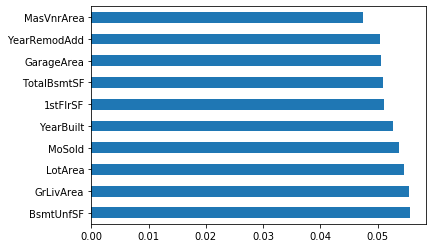

In [26]:
#Continuous values
X = continuous.iloc[:,0:32]
Y = continuous.iloc[:,-1]

model = ExtraTreesClassifier()
model.fit(X,Y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


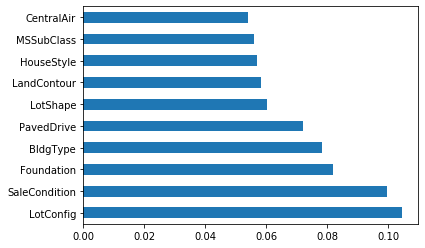

In [27]:
#Categorical values
X = categ.iloc[:,0:27]
Y = categ.iloc[:,-1]

model = ExtraTreesClassifier()
model.fit(X,Y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


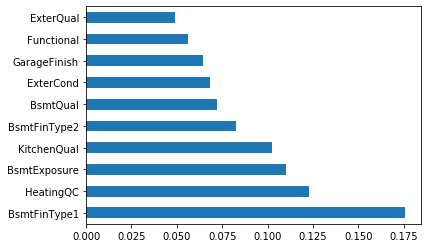

In [28]:
#Categorical values
X = categ_hier.iloc[:,0:13]
Y = categ_hier.iloc[:,-1]

model = ExtraTreesClassifier()
model.fit(X,Y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

If we compare the first result with the result of Extra trees Feature Importance analysis (ExtT), we see that there are some differences between them. One reason could be the use of OneHotEncoding to prepare the features, as it is not recomended in Decision Trees analysis.
Considering that, we would expect the ExtT analysis for the continuous features to be similar to the first analysis of the same features. Even thought the the best feature is not the same (GrLivArea for the first analysis and GarageArea for the second), both analysis found the two features as having one of the best relation to SalePrice.

With that said, I would still believe that GrLivArea best describes SalePrice.
